In [3]:
# CELL 0 — Imports and data loading

import numpy as np
import pandas as pd
from scipy.stats import invgamma, multivariate_normal
import matplotlib.pyplot as plt
from texas_gerrymandering_hb4.config import FINAL_CSV

plt.rcParams["figure.figsize"] = (7, 5)

df = pd.read_csv(FINAL_CSV)
df.head()


,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share
0,1,0.193575,0.439971,0.722970,0.407570,0.632532,0.184984,0.014875,0.142830,0.252671,0.728964
1,2,0.165232,0.406487,0.625270,0.417351,0.526751,0.125050,0.072934,0.255189,0.399379,0.577517
2,3,0.216761,0.465576,0.805445,0.273916,0.577914,0.112669,0.111327,0.172895,0.403698,0.573637
3,4,0.103462,0.321654,0.574190,0.222752,0.605524,0.099241,0.157600,0.108877,0.405732,0.575123
4,5,0.184465,0.429494,0.823171,0.310183,0.522819,0.159980,0.034848,0.261670,0.481179,0.498040


In [4]:
# CELL 1 — Construct design matrix and standardize predictors

y = df["dem_share"].values
n = len(y)

predictors = [
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    # omit pct_white to avoid perfect collinearity
    "polsby_popper",
    "reock",
    "schwartzberg",
]

X_raw = df[predictors].values

X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0, ddof=1)
X_std[X_std == 0] = 1.0

X_stdzd = (X_raw - X_mean) / X_std

X = np.column_stack([np.ones(n), X_stdzd])
p = X.shape[1]

predictors_with_intercept = ["intercept"] + predictors
predictors_with_intercept


['intercept',
 'pct_black',
 'pct_hispanic',
 'pct_asian',
 'polsby_popper',
 'reock',
 'schwartzberg']

In [5]:
# CELL 2 — Gibbs sampler for Bayesian regression

np.random.seed(123)

# Priors
beta0 = np.zeros(p)
tau2 = 10.0**2
V0 = tau2 * np.eye(p)

alpha0 = 2.0
beta0_sigma = 1.0

# Initialize
beta_curr = np.zeros(p)
sigma2_curr = 1.0

n_iter = 20000
burn_in = 5000

beta_samples = np.zeros((n_iter, p))
sigma2_samples = np.zeros(n_iter)

XtX = X.T @ X
Xty = X.T @ y
V0_inv = np.linalg.inv(V0)

for it in range(n_iter):
    # Sample beta | sigma2, y
    Vn_inv = XtX / sigma2_curr + V0_inv
    Vn = np.linalg.inv(Vn_inv)
    mn = Vn @ (Xty / sigma2_curr + V0_inv @ beta0)
    beta_curr = multivariate_normal.rvs(mean=mn, cov=Vn)

    # Sample sigma2 | beta, y
    residual = y - X @ beta_curr
    alpha_n = alpha0 + n / 2.0
    beta_n = beta0_sigma + 0.5 * (residual @ residual)
    sigma2_curr = invgamma.rvs(a=alpha_n, scale=beta_n)

    beta_samples[it, :] = beta_curr
    sigma2_samples[it] = sigma2_curr

beta_post = beta_samples[burn_in:, :]
sigma2_post = sigma2_samples[burn_in:]

beta_post.shape, sigma2_post.shape


((15000, 7), (15000,))

In [6]:
# CELL 3 — Posterior summaries for beta

def quantile_summary(samples, probs=(0.025, 0.25, 0.5, 0.75, 0.975)):
    return np.quantile(samples, probs, axis=0)

probs = (0.025, 0.25, 0.5, 0.75, 0.975)
beta_q = quantile_summary(beta_post, probs=probs)

rows = []
for j, name in enumerate(predictors_with_intercept):
    row = {"parameter": name, "mean": beta_post[:, j].mean()}
    for p_, qv in zip(probs, beta_q[:, j]):
        row[f"{int(p_ * 100)}%"] = qv
    rows.append(row)

beta_summary = pd.DataFrame(rows)
beta_summary


,parameter,mean,2%,25%,50%,75%,97%
0,intercept,0.464108,0.380585,0.436283,0.464466,0.492186,0.546279
1,pct_black,0.091549,0.004138,0.061643,0.091545,0.121346,0.180291
2,pct_hispanic,0.112556,0.008516,0.077519,0.112821,0.147135,0.218123
3,pct_asian,0.062041,-0.051676,0.023461,0.061903,0.100283,0.176881
4,polsby_popper,-0.106437,-0.781988,-0.335908,-0.103546,0.122527,0.570808
5,reock,0.022639,-0.089780,-0.014800,0.023315,0.061031,0.132766
6,schwartzberg,0.081097,-0.622901,-0.155858,0.076922,0.318070,0.790807


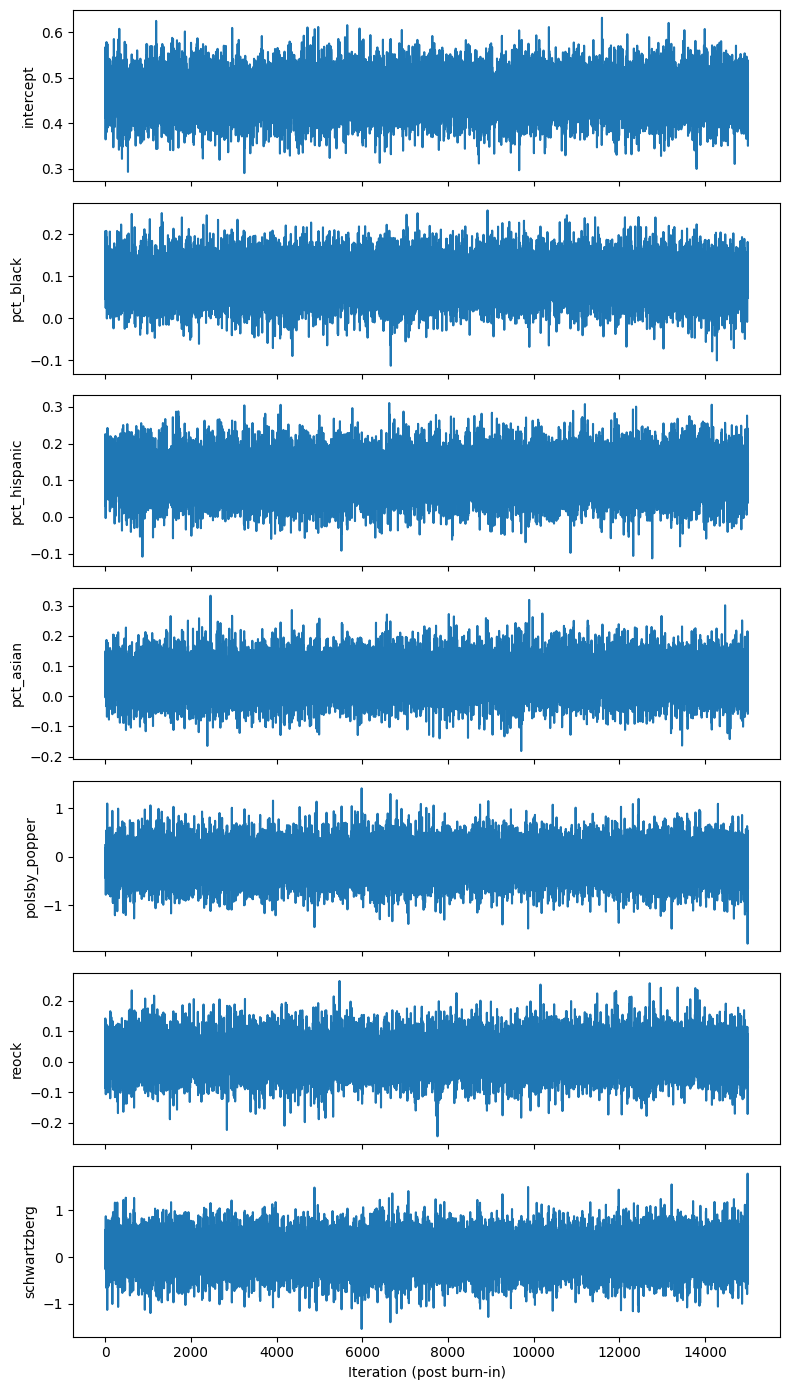

In [7]:
# CELL 4 — Trace plots (optional quick check)

fig, axes = plt.subplots(p, 1, figsize=(8, 2 * p), sharex=True)
for j, ax in enumerate(axes):
    ax.plot(beta_post[:, j])
    ax.set_ylabel(predictors_with_intercept[j])
axes[-1].set_xlabel("Iteration (post burn-in)")
plt.tight_layout()
plt.show()


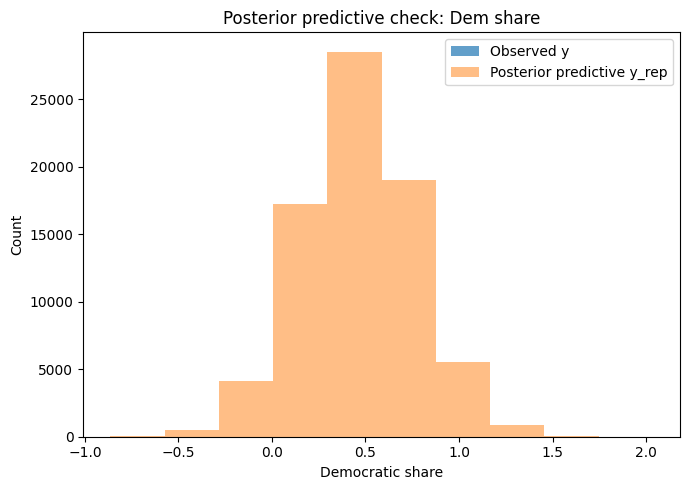

In [8]:
# CELL 5 — Posterior predictive draws

n_post = beta_post.shape[0]
n_rep = 2000
idx = np.random.choice(n_post, size=n_rep, replace=False)

y_rep = np.zeros((n_rep, n))

for s, k in enumerate(idx):
    beta_s = beta_post[k, :]
    sigma_s = np.sqrt(sigma2_post[k])
    mu_s = X @ beta_s
    y_rep[s, :] = np.random.normal(loc=mu_s, scale=sigma_s)

plt.hist(y, bins=10, alpha=0.7, label="Observed y")
plt.hist(y_rep.ravel(), bins=10, alpha=0.5, label="Posterior predictive y_rep")
plt.xlabel("Democratic share")
plt.ylabel("Count")
plt.legend()
plt.title("Posterior predictive check: Dem share")
plt.tight_layout()
plt.show()


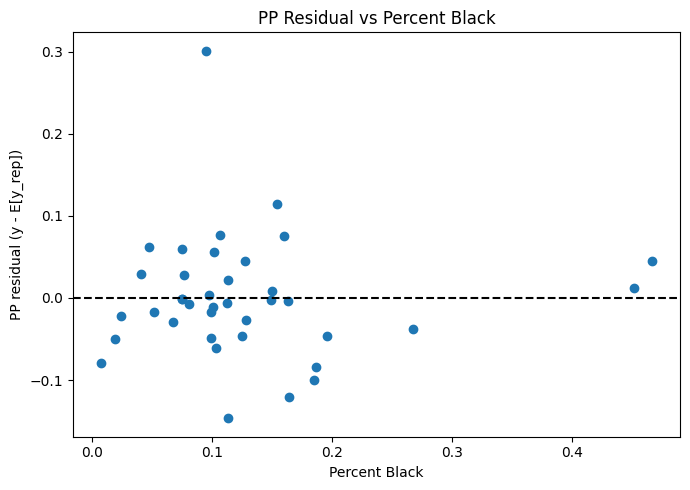

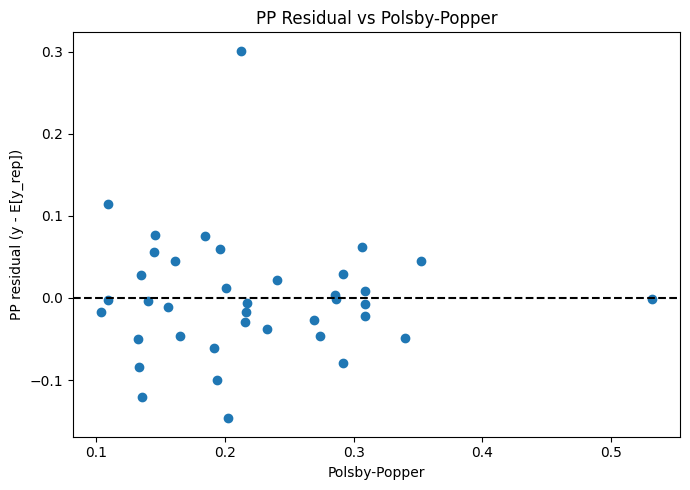

In [9]:
# CELL 6 — Posterior predictive mean and residuals

y_rep_mean = y_rep.mean(axis=0)
pp_resid = y - y_rep_mean

plt.scatter(df["pct_black"], pp_resid)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Percent Black")
plt.ylabel("PP residual (y - E[y_rep])")
plt.title("PP Residual vs Percent Black")
plt.tight_layout()
plt.show()

plt.scatter(df["polsby_popper"], pp_resid)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Polsby-Popper")
plt.ylabel("PP residual (y - E[y_rep])")
plt.title("PP Residual vs Polsby-Popper")
plt.tight_layout()
plt.show()


In [10]:
# CELL 7 — Save regression results

reg_results = pd.DataFrame({
    "district_id": df["district_id"],
    "dem_share": df["dem_share"],
    "pp_mean_dem_share": y_rep_mean,
    "pp_resid_dem_share": pp_resid,
})

reg_results.to_csv("regression_results.csv", index=False)
reg_results.head()


,district_id,dem_share,pp_mean_dem_share,pp_resid_dem_share
0,1,0.252671,0.352764,-0.100092
1,2,0.399379,0.445549,-0.046170
2,3,0.403698,0.409745,-0.006048
3,4,0.405732,0.423061,-0.017329
4,5,0.481179,0.405767,0.075412
